<a href="https://colab.research.google.com/github/eladses/sudoku-solver/blob/main/sudoku_solver_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**in development!! not done**

sudoku solver using openCV, pytesseract and py-sudoku to find solution of sudoku from image

---

**How To Use**

1. upload image
2. run imports
3. run functions
4. run algorethms

---

**How It Works**

1. extraction board
  1. finding biggest square
  2.
2. filtering cells
  1.
  2.


# Imports

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install py-sudoku
!pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,960 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
import numpy as np
import cv2

from imutils import contours
from google.colab.patches import cv2_imshow

from sudoku import Sudoku

from PIL import Image
import requests

import pytesseract
# pytesseract.pytesseract.tesseract_cmd = (
#     r'/usr/bin/tesseract'
# )

from tensorflow import keras
import matplotlib.pyplot as plt

# Upload

In [3]:
sudoku_url = 'https://i.redd.it/y4f37ifec7aa1.jpg'
img = np.array(Image.open(requests.get(sudoku_url, stream=True).raw))[:, :, ::-1].copy()

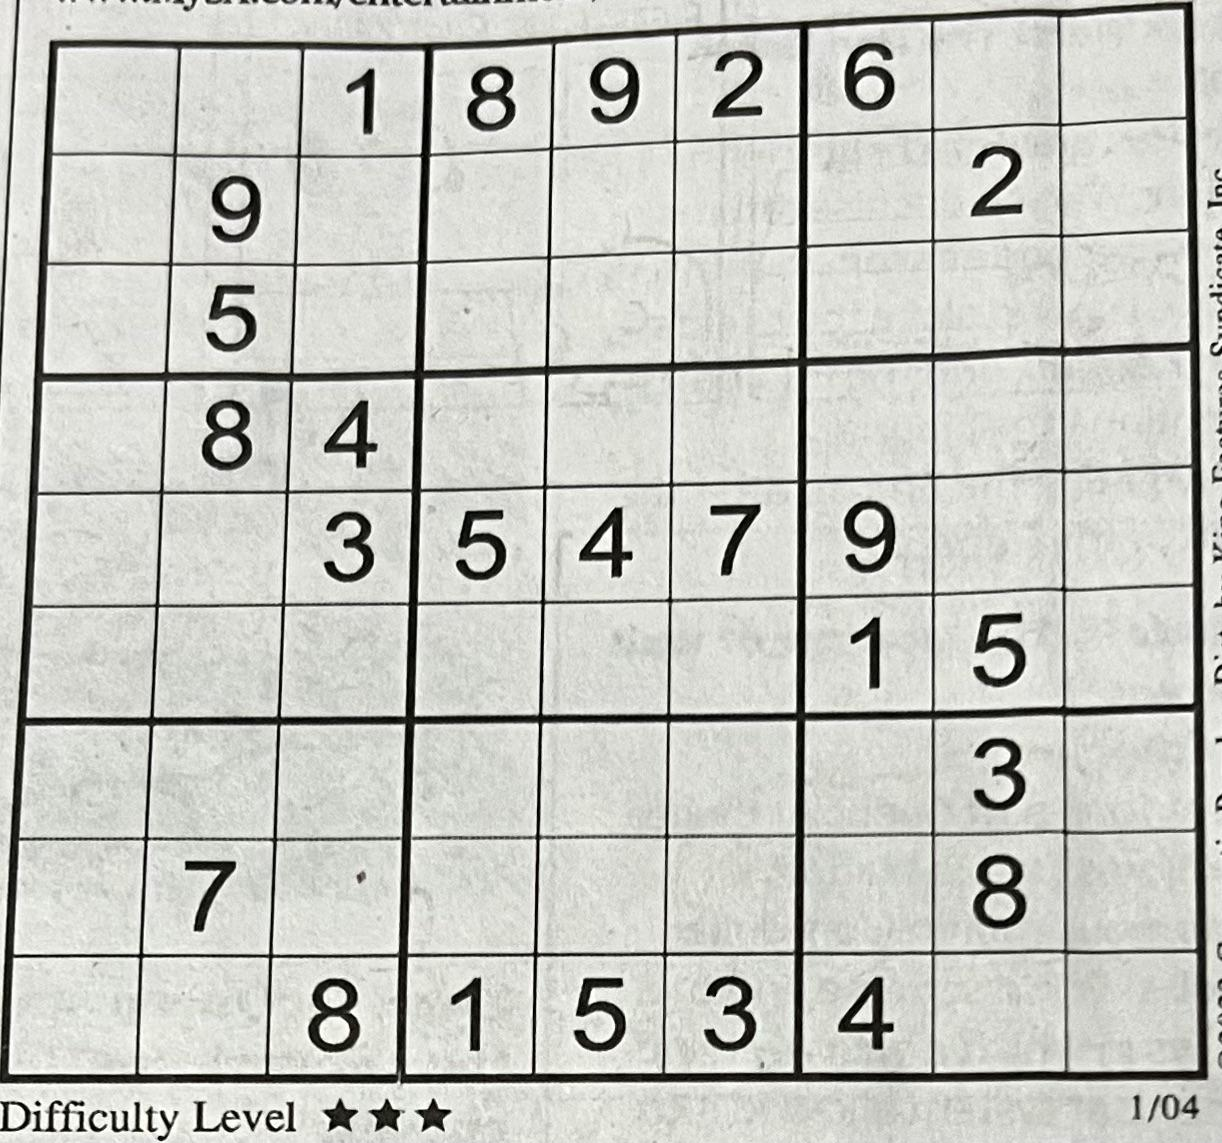

In [4]:
cv2_imshow(img)

# computer vision functions

In [5]:
def get_board(img):
    """corpes the board from image

    Args:
      img (cv2 image format) - the image of the sudocu

    Returns:
      board_img (cv2 image format) - the board corped for the image
    """
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    ret,thresh = cv2.threshold(gray,100,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    if len(contours) != 0:

        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        epsilon = 0.1 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points
        # draw the biggest contour (c) in green


    def order_points(pts):
        '''Rearrange coordinates to order:
          top-left, top-right, bottom-right, bottom-left'''
        rect = np.zeros((4, 2), dtype='float32')
        pts = np.array(pts)
        s = pts.sum(axis=1)
        # Top-left point will have the smallest sum.
        rect[0] = pts[np.argmin(s)]
        # Bottom-right point will have the largest sum.
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        # Top-right point will have the smallest difference.
        rect[3] = pts[np.argmin(diff)]
        # Bottom-left will have the largest difference.
        rect[1] = pts[np.argmax(diff)]
        # return the ordered coordinates
        return rect.astype('int').tolist()


    pt_A,pt_B,pt_C,pt_D=order_points([corners[0][0],corners[1][0],corners[2][0],corners[3][0]])

    # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, maxHeight - 1],
                            [maxWidth - 1, maxHeight - 1],
                            [maxWidth - 1, 0]])

    # Getting the homography.
    M = cv2.getPerspectiveTransform(input_pts,output_pts)

    return cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

In [6]:
def remove_small_contours(img,small_area=1000):
  """this founction remove small countours from the image. used to remove the numbers

  Args:
    img (cv2 image format)

  Returns:
    img (cv2 image format)
  """

  mask = np.zeros(img.shape[:2], dtype=img.dtype)
  cnts, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
      area = cv2.contourArea(c)
      if area < small_area:
        x, y, w, h = cv2.boundingRect(c)
        cv2.drawContours(mask, [c], 0, (255), -1)

  return img-mask


def get_cells(board_img,board_lines_mask):
    """corpes the cells from the board

    Args:
      board_img (cv2 image format) - board
      board_lines_mask (cv2 image format) - board lines

    Returns:
      board_img (cv2 image format) - the board corped for the image
    """

    invert = 255 - board_lines_mask
    cnts,_ = cv2.findContours(invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

    newBoard = board.copy()
    rectangles=[]
    for c in cnts:
      if(cv2.contourArea(c)<0**2): continue
      x,y,w,h = cv2.boundingRect(c)
      if(w<board_img.shape[0]/18 or h<board_img.shape[1]/18): continue
      # print(cv2.boundingRect(c))
      rectangles.append(cv2.boundingRect(c))
    # for rectangle in rectangles:
    #   cv2_imshow(board[rectangle[0]:(rectangle[0] + rectangle[2]),rectangle[1]:(rectangle[1]+ rectangle[3])])

    a,b,_=board_img.shape

    rectangles = sorted(rectangles, key=lambda x: int(x[0]/a*9)/100+int(x[1]/b*9), reverse=False)
    i=0
    for c in rectangles:
      x,y,w,h=c
      cv2.rectangle(newBoard, (x, y), (x + w, y + h), (255,0,0), 1)
      cv2.putText(newBoard, str(i), (x,y+h),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2,cv2.LINE_AA)
      i+=1

    # cv2_imshow(newBoard)

    if len(rectangles)!=81:
      return

    return rectangles




In [17]:
def get_cell_content(cell):

  cell_copy = cell.copy()
  # Convert the image to gray scale
  gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)

  # Performing OTSU threshold
  ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

  # Specify structure shape and kernel size.
  # Kernel size increases or decreases the area
  # of the rectangle to be detected.
  # A smaller value like (10, 10) will detect
  # each word instead of a sentence.
  rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

  # Applying dilation on the threshold image
  dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)

  # Finding contours
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    # Drawing a rectangle on copied image
    rect = cv2.rectangle(cell_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Cropping the text block for giving input to OCR
    cropped = cell_copy[y:y + h, x:x + w]

    # Open the file in append mode
    cv2_imshow(cell_copy)
    # Apply OCR on the cropped image
    text = pytesseract.image_to_string(cropped)
    print(text)

# sudoku functions

In [ ]:
puzzle = Sudoku(3).difficulty(0.5)
def load_sudoku(board):
  return Sudoku(3, 3, board=board)
def solve_sudoku(sudoku):
  return puzzle.solve()

In [ ]:
game = load_sudoku(puzzle.board)
print(game.board)
print(solve_sudoku(game).board)

# Program

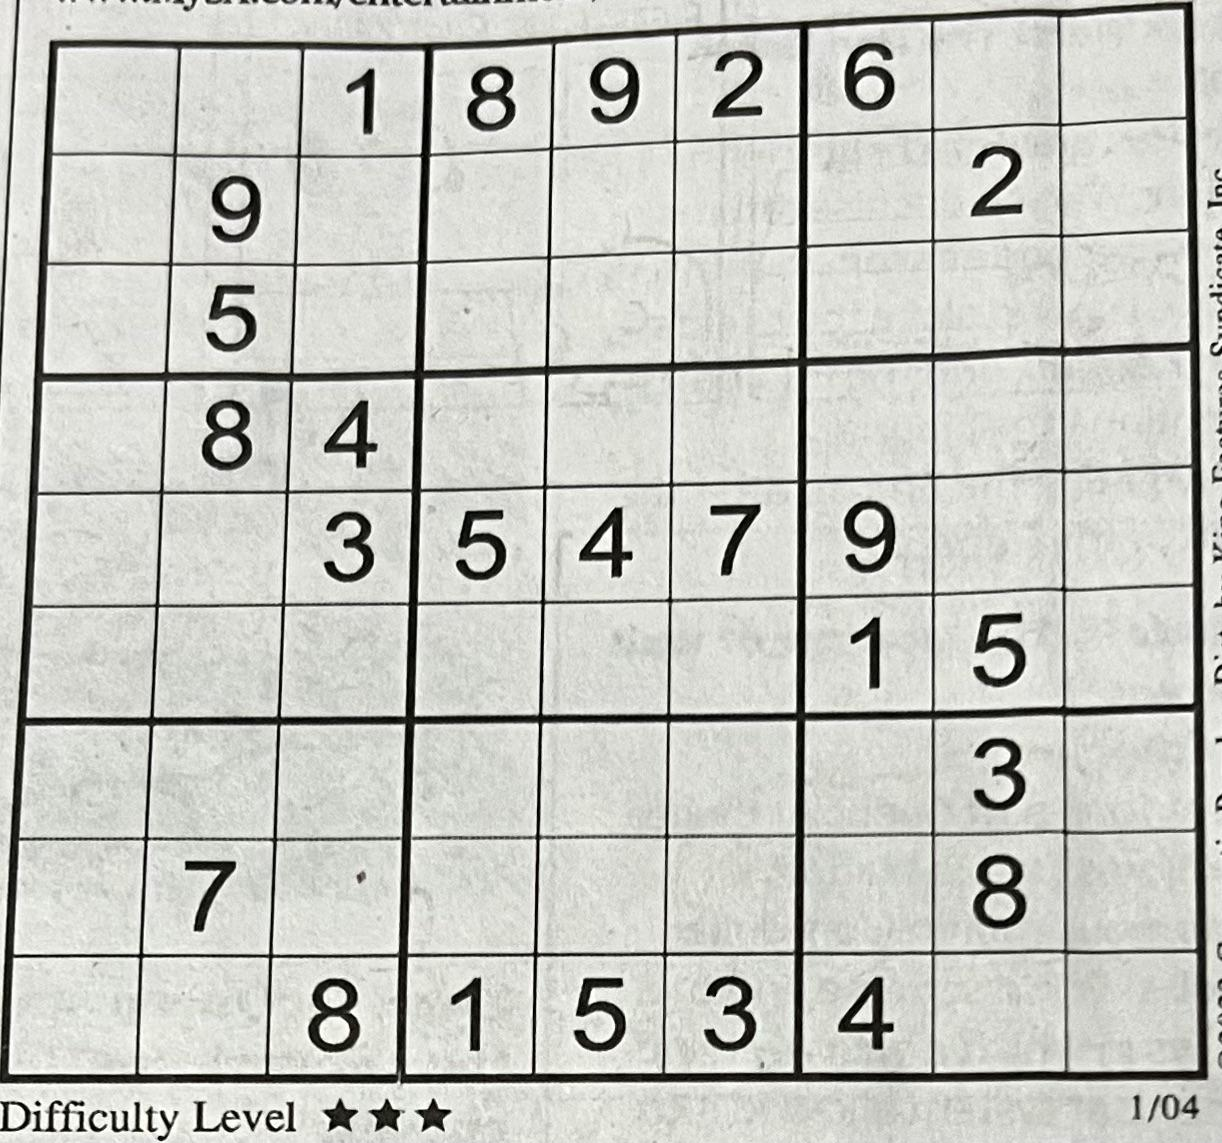

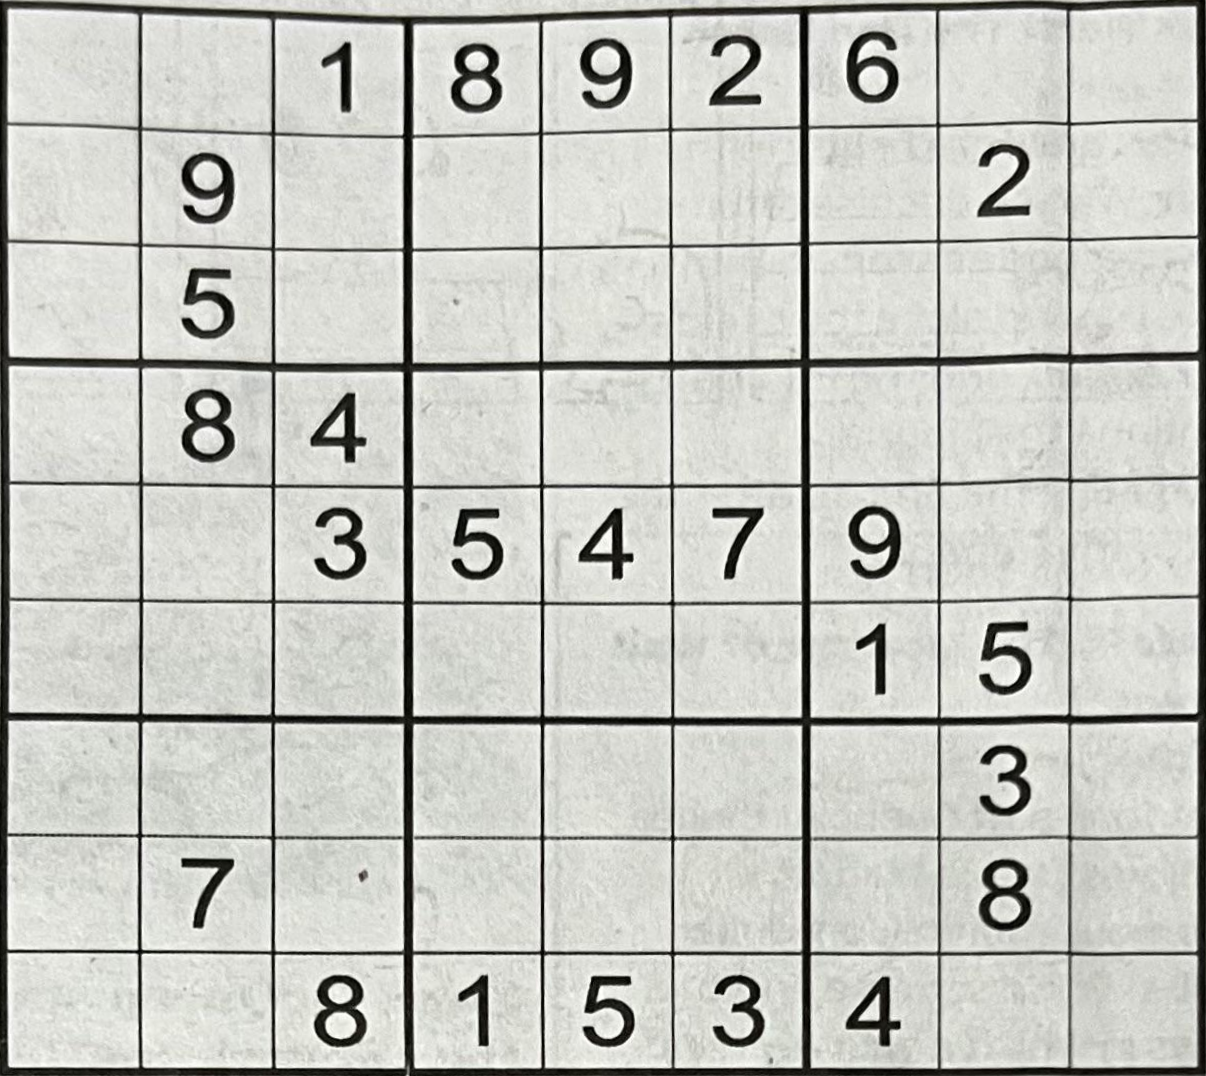

In [9]:
# crop board
cv2_imshow(img)
board=get_board(img)

cv2_imshow(board)

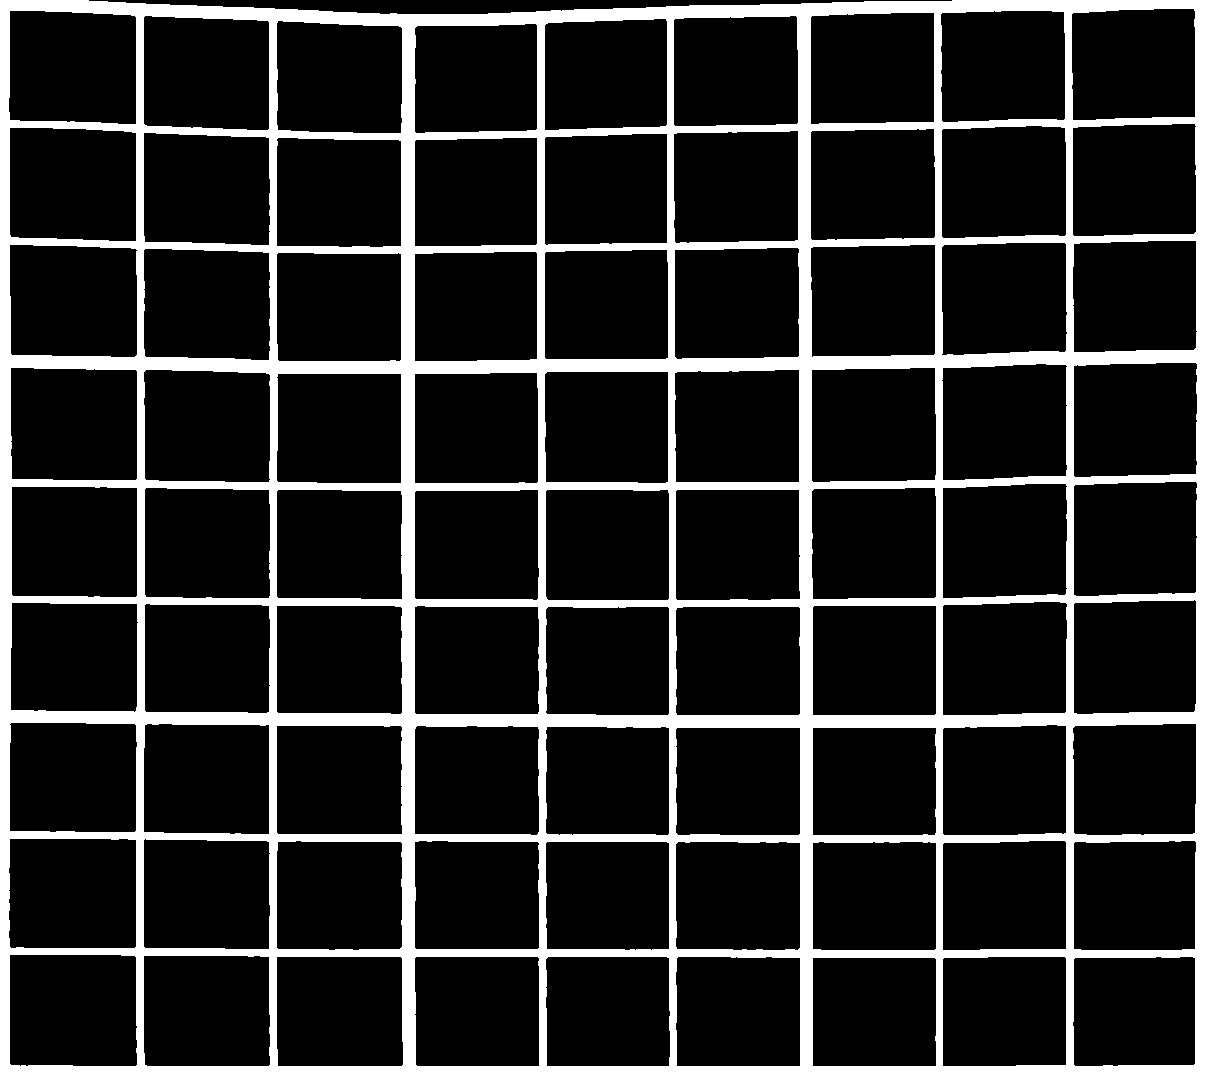

In [10]:
# get board lines
board_gray = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
_,board_thresh = cv2.threshold(board_gray,150,255,cv2.THRESH_BINARY_INV)
board_clean = remove_small_contours(board_thresh,board_thresh.shape[0]*board_thresh.shape[1]/260)

kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(board_clean, kernel, iterations=1)
cv2_imshow(dilated_mask)


In [11]:
rectangels=get_cells(board,dilated_mask)

print(rectangels)

cells=[board[y:y+ h,x:x + w] for (x,y,w,h) in rectangels]

[(10, 128, 126, 113), (9, 11, 127, 113), (144, 133, 126, 112), (144, 16, 125, 114), (277, 21, 125, 112), (415, 24, 122, 109), (545, 19, 122, 111), (674, 131, 124, 112), (674, 16, 124, 110), (811, 129, 124, 111), (811, 13, 123, 111), (942, 126, 124, 112), (941, 11, 124, 111), (1073, 124, 123, 112), (1072, 9, 123, 111), (10, 245, 127, 112), (144, 249, 126, 111), (277, 253, 124, 108), (277, 138, 124, 109), (415, 252, 122, 109), (415, 138, 122, 108), (545, 250, 123, 109), (545, 134, 122, 111), (675, 248, 124, 111), (811, 245, 124, 112), (942, 243, 125, 112), (1073, 241, 124, 111), (11, 368, 126, 112), (144, 370, 126, 112), (277, 374, 124, 109), (415, 373, 123, 110), (545, 372, 123, 111), (675, 370, 124, 112), (812, 368, 124, 114), (942, 364, 125, 116), (1074, 363, 123, 114), (12, 487, 125, 110), (145, 488, 125, 110), (277, 490, 125, 109), (415, 490, 124, 110), (546, 490, 123, 110), (676, 490, 124, 110), (812, 488, 124, 111), (943, 484, 124, 114), (1074, 482, 123, 114), (11, 603, 127, 109),

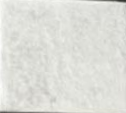

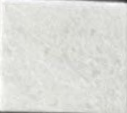

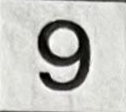

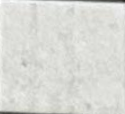

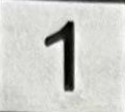

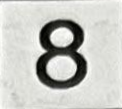

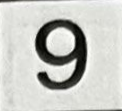

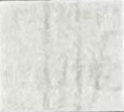

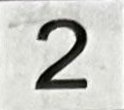

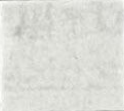

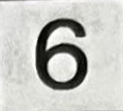

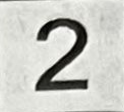

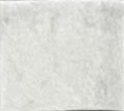

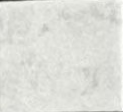

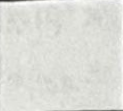

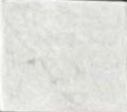

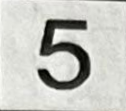

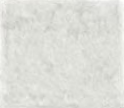

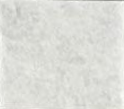

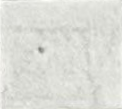

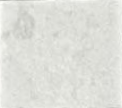

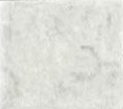

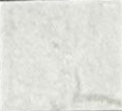

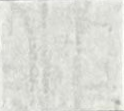

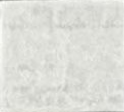

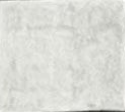

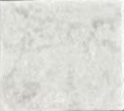

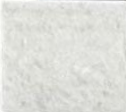

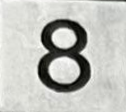

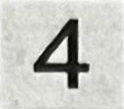

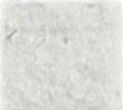

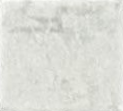

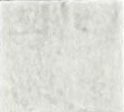

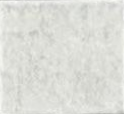

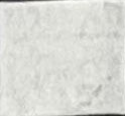

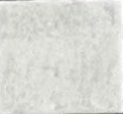

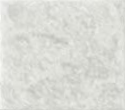

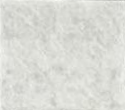

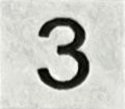

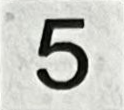

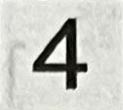

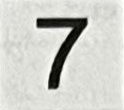

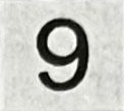

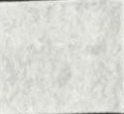

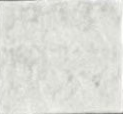

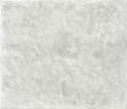

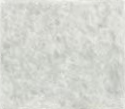

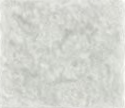

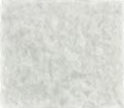

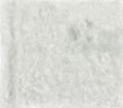

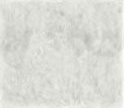

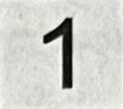

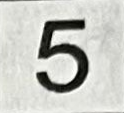

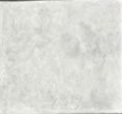

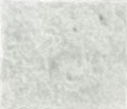

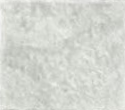

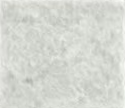

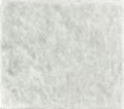

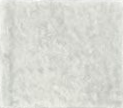

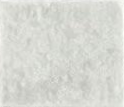

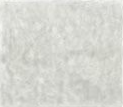

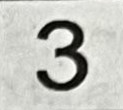

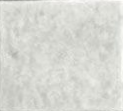

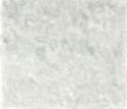

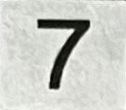

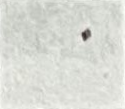

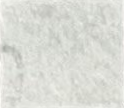

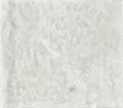

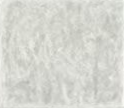

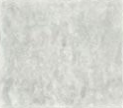

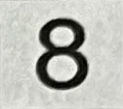

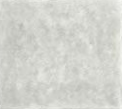

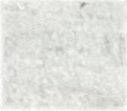

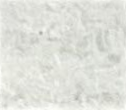

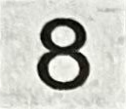

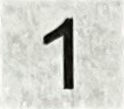

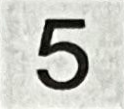

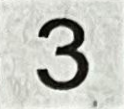

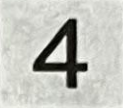

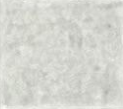

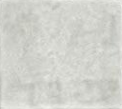

In [12]:
for cell in cells:
  cv2_imshow(cell)

In [14]:
cells_gray=[cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY) for cell in cells]
# for cell in cells:

# cells_resizeds=[cv2.resize(gray,(28,28)) for gray in cells_gray]
# cells_resizeds=[cv2.threshold(resized,127,255,cv2.THRESH_BINARY_INV)[1]/255 for resized in cells_resizeds]

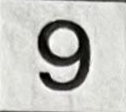

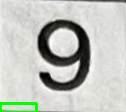

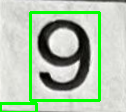

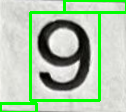

In [19]:
# pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/pytesseract'
cell=cells[2]
cv2_imshow(cell)
# gray=cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
# (thresh, bw_img) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cell_BGR = cv2.cvtColor(cell, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(cell_BGR)
get_cell_content(cell)
# print("num:" +txt)